In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
import nltk

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
## needed variables
'''
1.  encoding_train 
2.  encoding_val
3.  encoding_test
4.  VQG_training_dataset.txt
5.  unique
6.  max_len
7.  samples_per_epoch
8.  word2idx, idx2word
9.  caps
10. max_len


'''


'\n1.  encoding_train \n2.  encoding_val\n3.  encoding_test\n4.  VQG_training_dataset.txt\n5.  unique\n6.  max_len\n7.  samples_per_epoch\n8.  word2idx, idx2word\n9.  caps\n10. max_len\n\n\n'

In [4]:
created_files_dir ='vqg_created_files/'

In [5]:
with open(created_files_dir + "word2idx.pickle","rb")  as fh:
    word2idx= pickle.load(fh)

In [6]:
with open(created_files_dir + "idx2word.pickle","rb")  as fh:
    idx2word= pickle.load(fh)

In [7]:
with open(created_files_dir + "encoded_images_inceptionV3.p","rb")  as fh:
    encoding_train= pickle.load(fh)

In [8]:
with open(created_files_dir + "encoded_images_test_inceptionV3.p","rb")  as fh:
    encoding_test= pickle.load(fh)

In [9]:
with open(created_files_dir + "encoded_images_val_inceptionV3.p","rb")  as fh:
    encoding_val= pickle.load(fh)

In [10]:
unique = pickle.load(open(created_files_dir+'unique.p', 'rb'))

In [11]:
max_len = pickle.load(open(created_files_dir+'max_len.pickle', 'rb'))

In [12]:
caps = pickle.load(open(created_files_dir+'caps.pickle', 'rb'))

In [13]:
images = 'VQg_Dataset/VQG_Dataset/'

In [14]:
# samples_per_epoch = pickle.load(open(created_files_dir+'samples_per_epoch.pickle', 'rb'))
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [15]:
vocab_size = len(unique)

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [16]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv(created_files_dir+'VQG_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Let's create the model

In [17]:
embedding_size = 300

Input dimension is 4096 since we will feed it the encoded version of the image.

In [18]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [19]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Merging the models and creating a softmax classifier

In [20]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [21]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [22]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 46, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_3 (Dense)              (None, 9050)              4642650   
_________________________________________________________________
activation_1 (Activation)    (None, 9050)              0         
Total params: 9,760,554
Trainable params: 9,760,554
Non-trainable params: 0
_________________________________________________________________


In [23]:
batch_size = 128
samples_pr_epoch = samples_per_epoch

In [24]:
from keras.models import model_from_json

In [25]:
def save_the_model(model,acc,loss,epoch):

    # serialize model to JSON
    model_json = model.to_json()
    with open(created_files_dir+"models/"+"model_{}epoch_{}loss_{}acc.json".format(epoch,loss,acc), "w",encoding='utf-8') as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(created_files_dir+"models/"+"model_{}epoch_{}loss_{}acc.h5".format(epoch,loss,acc))
    print("Saved model to disk")

In [26]:
def load_the_model(model_path,weights_path):
    
    # load json and create model
    json_file = open(model_path, 'r',encoding='utf-8')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_path)
    print("Loaded model from disk")
    return loaded_model

In [ ]:
# final_model = load_the_model(created_files_dir+'models/'+'model_5epoch_3.3383loss_0.4117acc.h5',created_files_dir+'models/'+'model_5epoch_3.3383loss_0.4117acc.json')

In [30]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=4, 
                          verbose=2)

Epoch 1/4
394s - loss: 4.2200 - acc: 0.3004
Epoch 2/4
406s - loss: 3.6409 - acc: 0.3642
Epoch 3/4
405s - loss: 3.4702 - acc: 0.3867
Epoch 4/4
402s - loss: 3.4763 - acc: 0.3987


In [39]:
save_the_model(final_model,str(0.3987),str(3.4763),str(4))

Saved model to disk


In [42]:
final_model = load_the_model(created_files_dir+'models/'+'model_4epoch_3.4763loss_0.3987acc.json',created_files_dir+'models/'+'model_5epoch_3.3383loss_0.4117acc.h5')
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Loaded model from disk


In [43]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=3, 
                          verbose=2)

Epoch 1/3
400s - loss: 3.3896 - acc: 0.4198
Epoch 2/3
409s - loss: 3.3205 - acc: 0.4261
Epoch 3/3
413s - loss: 3.2715 - acc: 0.4307


In [44]:
save_the_model(final_model,str(0.43),str(3.2715),str(7))

Saved model to disk


In [ ]:
final_model = load_the_model(created_files_dir+'models/'+'model_7epoch_3.2715loss_0.43acc.json',created_files_dir+'models/'+'model_7epoch_3.2715loss_0.43acc.h5')
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [26]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=4, 
                          verbose=2)

Epoch 1/4
383s - loss: 3.2768 - acc: 0.4358
Epoch 2/4
405s - loss: 3.2757 - acc: 0.4407
Epoch 3/4
403s - loss: 3.2377 - acc: 0.4448
Epoch 4/4
405s - loss: 3.2153 - acc: 0.4510


In [27]:
save_the_model(final_model,str(0.4510),str(3.2153),str(11))

Saved model to disk


In [27]:
final_model = load_the_model(created_files_dir+'models/'+'model_11epoch_3.2153loss_0.451acc.json',created_files_dir+'models/'+'model_11epoch_3.2153loss_0.451acc.h5')
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Loaded model from disk


In [ ]:
final_model.fit_generator(data_generator(batch_size=batch_size*2), steps_per_epoch=samples_pr_epoch//(batch_size*2), epochs=4,verbose=2)

Epoch 1/4
264s - loss: 3.0140 - acc: 0.4724
Epoch 2/4


In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
# checkpoint
filepath=created_files_dir+'models/'  + "weights-improvement-epoch{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict funtion

In [34]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [35]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

Normal Max search: What kind of cat is that
Beam Search, k=3: What kind of cat is that
Beam Search, k=5: What is the cat's name
Beam Search, k=7: What is the cat's name


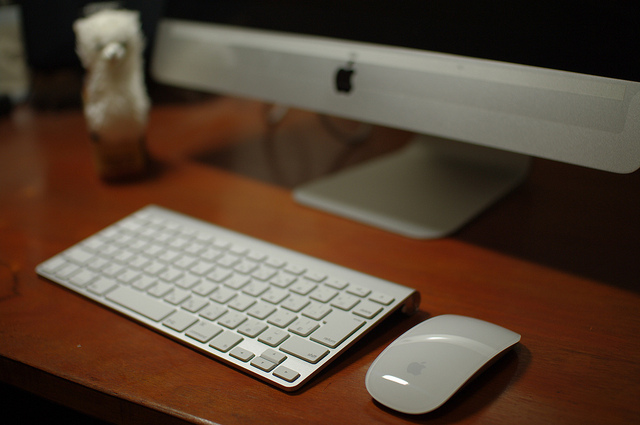

In [38]:
im = 'VQg_dataset/VQG_Dataset/151170.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: How long have you been skiing
Beam Search, k=3: How long have you been skiing
Beam Search, k=5: Where is he skiing
Beam Search, k=7: Where is she skiing


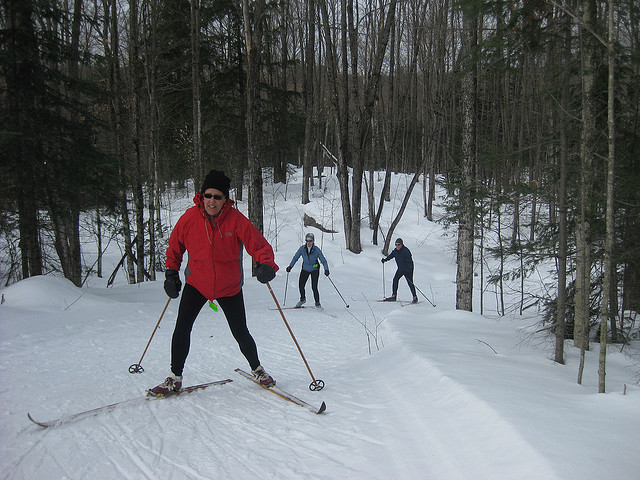

In [39]:

im = 'VQg_dataset/VQG_Dataset/400094.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What kind of tie is that
Beam Search, k=3: What kind of tie is that
Beam Search, k=5: What kind of tie is that
Beam Search, k=7: What kind of tie is that


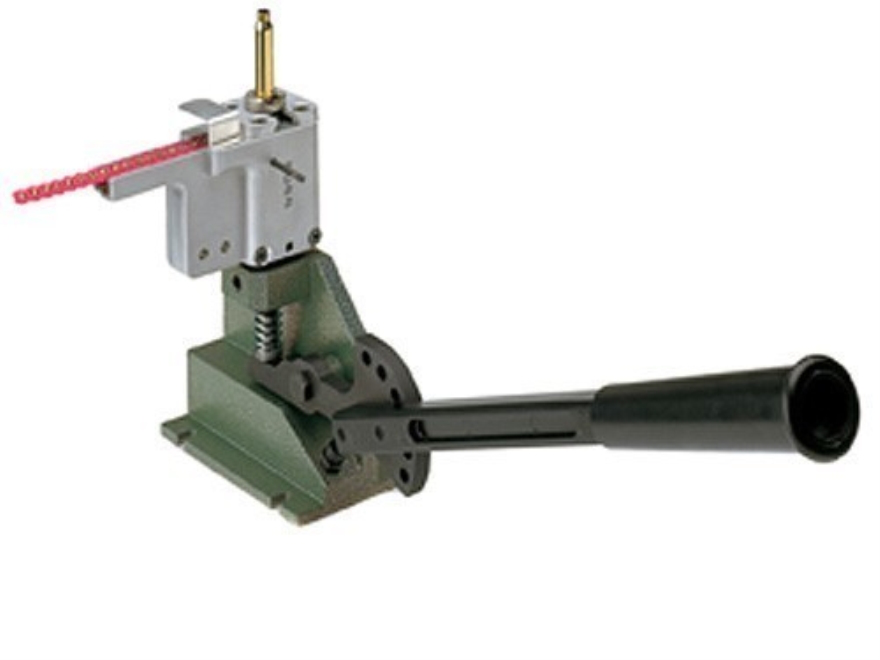

In [40]:
im = 'VQg_dataset/VQG_Dataset/bf1f3ad3-a667-49e3-9148-f0ad2d018b1b.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What kind of bike is that
Beam Search, k=3: What kind of bike is that
Beam Search, k=5: What kind of bike is that
Beam Search, k=7: What kind of motorcycle is that


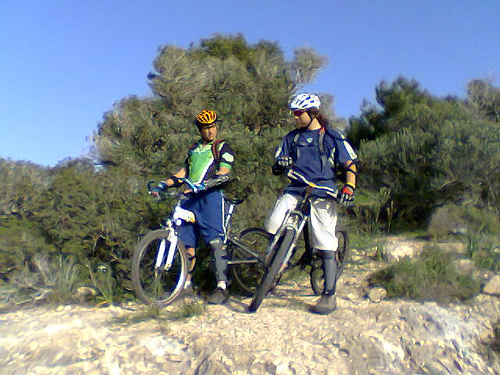

In [41]:
im = 'VQg_dataset/VQG_Dataset/42493.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What is the cat's name
Beam Search, k=3: What is the cat's name
Beam Search, k=5: What is the cat's name
Beam Search, k=7: What is the cat's name


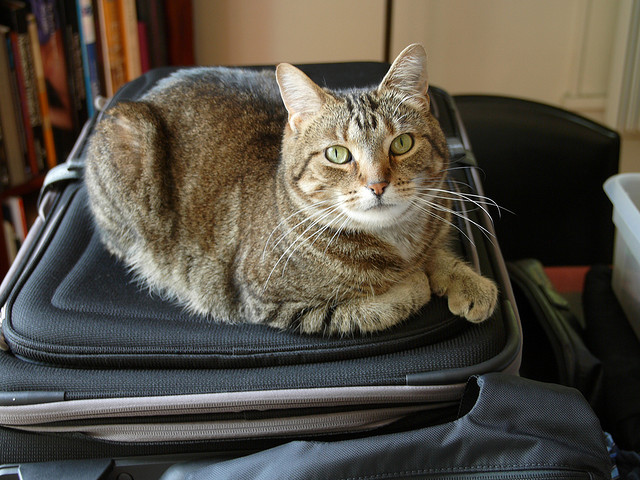

In [42]:
im = 'VQg_dataset/VQG_Dataset/308549.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)